In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec
import os
import numpy as np

import rasterio
import matplotlib 
import matplotlib.pyplot as plt
import fiona
from rasterio.mask import mask
import geopandas as gpd
import matplotlib as mpl

import rasterio.features
from affine import Affine
from shapely.geometry import shape

In [3]:
def read_file_geopandas(raster_file, aoi_file):
    with fiona.open(aoi_file, 'r') as vector, \
            rasterio.open(raster_file, 'r') as raster:
        
        aoi_viz = gpd.read_file(aoi_file)

        # read the subset of the data into a numpy array
#             window = ((lr[0], ul[0]+1), (ul[1], lr[1]+1))
        data = raster.read(1, window=aoi_viz.total_bounds[[0,2,1,3]])

        # create an affine transform for the subset data
        t = raster.transform
        shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

        # rasterize the geometry
        mask = rasterio.features.rasterize(
            [(geometry, 0)],
            out_shape=data.shape,
            transform=shifted_affine,
            fill=1,
            all_touched=True,
            dtype=np.uint8)

        masked_data = np.ma.array(data=data, mask=mask.astype(bool))

        return masked_data

In [5]:
def read_file_shapely(raster_file, aoi_file):
    with fiona.open(aoi_file, 'r') as vector, \
            rasterio.open(raster_file, 'r') as raster:
        
        for feature in vector:
            # create a shapely geometry
            # this is done for the convenience for the .bounds property only
            geometry = shape(feature['geometry'])

            # get pixel coordinates of the geometry's bounding box
            ul = raster.index(*geometry.bounds[0:2])
            lr = raster.index(*geometry.bounds[2:4])

            # read the subset of the data into a numpy array
            window = ((lr[0], ul[0]+1), (ul[1], lr[1]+1))
            print(window)
            data = raster.read(1, window=window)

            # create an affine transform for the subset data
            t = raster.transform
            shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

            # rasterize the geometry
            mask = rasterio.features.rasterize(
                [(geometry, 0)],
                out_shape=data.shape,
                transform=shifted_affine,
                fill=1,
                all_touched=True,
                dtype=np.uint8)
        
            masked_data = np.ma.array(data=data, mask=mask.astype(bool))

            return masked_data

In [4]:
def read_file(raster, masked):
    with rasterio.open(raster) as src:
        out_image = src.read(1)
        masked_data = np.ma.array(data=out_image, mask=masked.astype(bool))
        return masked_data

In [9]:
def read_file(raster, shape):
    with rasterio.open(raster) as src:
        out_image, out_transform = mask(src, shape, crop=True)
        out_image = out_image.astype(np.float32)
        out_image[out_image<-3e+38] = np.nan
        out_image = out_image.squeeze()
        return out_image

In [8]:
def read_file_int(raster, shape):
    with rasterio.open(raster) as src:
        out_image, out_transform = mask(src, shape, crop=True)
        out_image = out_image.astype(np.float32)
        out_image[out_image>2e+09] = np.nan
        out_image = out_image.squeeze()
        return out_image

In [9]:
def read_file(raster, shape):
    with rasterio.open(raster) as src:
        out_image, out_transform = mask(src, shape, crop=True)
        out_image = out_image.astype(np.float32)
        out_image[out_image<-3e+38] = np.nan
        out_image = out_image.squeeze()
        return out_image

In [7]:
def read_file_int(raster, shape):
    with rasterio.open(raster) as src:
        out_image, out_transform = mask(src, shape, crop=True)
        out_image = out_image.astype(np.float32)
        out_image[out_image<-9000] = np.nan
        out_image = out_image.squeeze()
        return out_image

In [10]:
indir = os.path.join(r'F:\acoca\research\gee\dataset\AMZ\implementation')
outdir = r'E:\acocac\research\AMZ\img\c6\ancillary'

aoi_file = os.path.join(indir, 'aoi', 'amazon_raisg.shp')
aoi_viz = gpd.read_file(aoi_file)

# ref_raster = os.path.join(indir, 'ancillary', 'gee', 'access.tif')
# aoi = maskvector(aoi_file, ref_raster)

# read files
with fiona.open(aoi_file, "r") as shapefile:
    aoi = [feature["geometry"] for feature in shapefile]
    
access = read_file_int(os.path.join(indir, 'ancillary', 'processed', 'external', 'access.tif'), aoi)
elevation = read_file_int(os.path.join(indir, 'ancillary', 'processed', 'external', 'srtm.tif'), aoi)
slope = read_file(os.path.join(indir, 'ancillary', 'processed', 'external', 'slope.tif'), aoi)
prec = read_file(os.path.join(indir, 'ancillary', 'processed', 'external', 'bio12.tif'), aoi)
pas_conservation = read_file_int(os.path.join(indir, 'ancillary', 'processed', 'external', 'distance_PAs_conservation_AMZ.tif'), aoi)
pas_exploitation = read_file_int(os.path.join(indir, 'ancillary', 'processed', 'external', 'distance_PAs_exploitation_AMZ.tif'), aoi)

C:\Users\PAPAZ\AppData\Local\Continuum\anaconda2\envs\geothesis\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [11]:
magma_cmap = matplotlib.cm.get_cmap('magma')

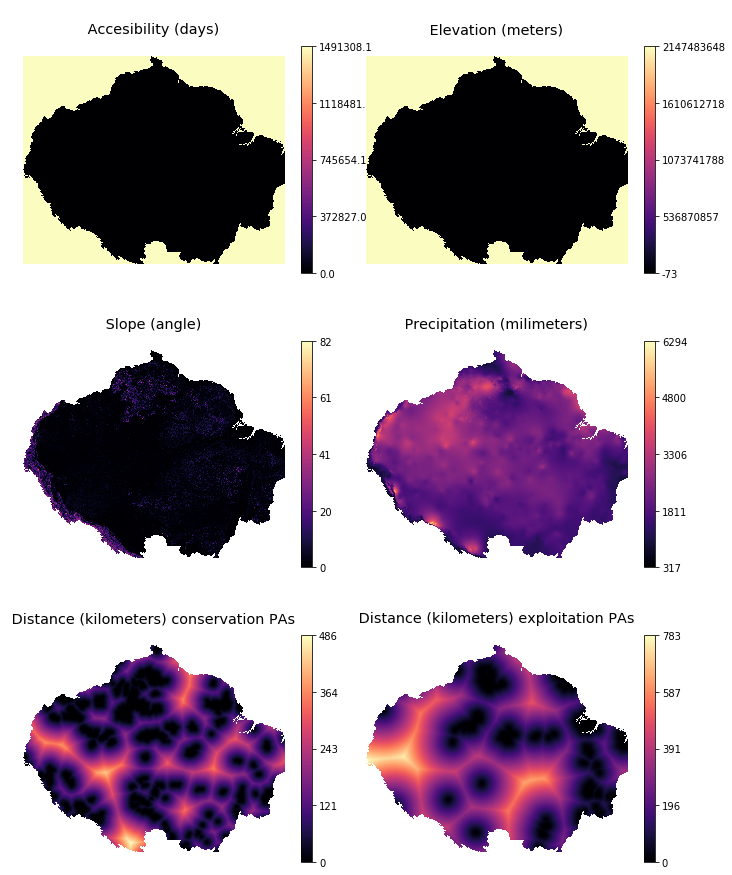

In [14]:
gs0 = gridspec.GridSpec(3, 2,  hspace=0.3, wspace=0.05, height_ratios= [1, 1, 1])
arrays_l1 = [access, elevation, slope, prec, pas_conservation, pas_exploitation]

fig = plt.figure(figsize=(12, 15), constrained_layout=False)
for i, arr in enumerate(arrays_l1):
    if i == 0:
        ax00 = fig.add_subplot(gs0[0, 0])
        ax00.set_title('\n Accesibility (days) \n', fontsize='x-large')
        arr = arr/(60*24)
        format_bar = "%.1f"
    else:
        if i == 1:
            ax00 = fig.add_subplot(gs0[0, 1])
            ax00.set_title('\n Elevation (meters) \n', fontsize='x-large')
        elif i == 2:
            ax00 = fig.add_subplot(gs0[1, 0])
            ax00.set_title('\n Slope (angle) \n', fontsize='x-large')
        elif i == 3:
            ax00 = fig.add_subplot(gs0[1, 1])
            ax00.set_title('\n Precipitation (milimeters) \n', fontsize='x-large')
        elif i == 4:
            ax00 = fig.add_subplot(gs0[2, 0])
            ax00.set_title('\n Distance (kilometers) conservation PAs \n', fontsize='x-large')
            arr = (arr*231.91560544825498)/1000
        elif i == 5:
            ax00 = fig.add_subplot(gs0[2, 1])
            ax00.set_title('\n Distance (kilometers) exploitation PAs \n', fontsize='x-large')
            arr = (arr*231.91560544825498)/1000
            
        format_bar = "%.0f"
        
#     im = ax00.imshow(np.log10(arr+0.000001), cmap=magma_cmap, interpolation='none', extent=aoi_viz.total_bounds[[0,2,1,3]], norm=mpl.colors.Normalize(vmin=np.nanmin(np.log10(arr)),vmax=np.nanmax(np.log10(arr))))   
    im = ax00.imshow(arr, cmap=magma_cmap, interpolation='none', extent=aoi_viz.total_bounds[[0,2,1,3]], norm=mpl.colors.Normalize(vmin=np.nanmin(arr),vmax=np.nanmax(arr)))   
#     aoi_viz.plot(edgecolor='gray', linewidth=1, facecolor='None', ax=ax00, zorder=3)

    v = np.linspace(np.nanmin(arr), np.nanmax(arr), 5, endpoint=True)

    ax00.axis('off')
    cb = plt.colorbar(im, orientation='vertical', ticks=v, format=format_bar)

plt.show()

# fig.savefig(os.path.join(outdir,'aux_data.png'), bbox_inches='tight',pad_inches = 0, dpi=150)
# plt.close()